本节目的： 前面(7-9)共3节通过手写代码理解了惩罚线性算法的原理，在此基础上，调用相关python算法包就会心中有数。

scikit-learn算法包已经实现了套索、LARS以及ElasticNet回归。

详细清单：http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

【注意】 scikit-learn算法包采用$\alpha$作为系数惩罚项乘子，采用**l1_ratio**作为ElasticNet中套索惩罚项的比例乘子。和前面的公式表示不一样。

## 1) 多变量回归：预测红酒口感

之所以把红酒口感看成回归问题，是因为口感是有程度的、有序的， 而分类问题本质只有区别而无优劣次序。

### 构建并测试模型以预测红酒的口感

 **构建模型的第一步**是通过样本外的性能来判断模型能否满足性能要求。
 
 本例展示了用算法包sklearn.linear_model.LassoCV进行**套索线性回归**的**10折交叉验证**。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LassoCV

# 获取红酒数据集
target_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(target_url, header=0, sep=";")
df.columns = ['非挥发性酸','挥发性酸','柠檬酸', '残留糖分', '氯化物', '游离二氧化硫','总二氧化硫', '密度', 
              'PH值', '亚硝酸盐', '酒精含量', '品质']

# 标准化 切分属性和标签
norm_df = (df - df.mean())/df.std()
xData = df.values[:,:-1]; yData = df.values[:,-1] 
xNormData = norm_df.values[:,:-1]; yNormData = norm_df.values[:,-1] 
m, n = xData.shape

#  标准化与否的选择
# xx = xData; 
xx = xNormData
#y = yData
y = yNormData

# 调用sklearn.linear_model中的LassoCV 
wineModel = LassoCV(cv=10).fit(xx,y)

plt.figure()
plt.plot(wineModel.alphas_,wineModel.mse_path_,':')
plt.plot(wineModel.alphas_, wineModel.mse_path_.mean(axis=-1),label='交叉验证结果的均方误差的平均值',linewidth=2)
plt.axvline(wineModel.alpha_,linestyle='--',label='交叉验证表现最佳的alpha值')
plt.semilogx()
plt.legend()
ax = plt.gca()
ax.invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('均方误差')
plt.axis('tight')
plt.show()

#print out the value of alpha that minimizes the Cv-error
print ("最小均方误差对应的alpha值  ",wineModel.alpha_)
print ("最小均方误差：", min(wineModel.mse_path_.mean(axis=-1)))

最小均方误差对应的alpha值   0.013552906532921512
最小均方误差： 0.6651686698682027


此图是X、y都做标准化的情况。 如果我们尝试对X、y是否做标准化的其它选择后(调整代码中xx,y的赋值后重新绘图)，我们会发现：

1） X标准化，y不做标准化： 虽然均方误差显著变小，但图形很类似没有本质区别，仅仅因为对标签进行标准化会失去与原始数据的关联而已。实际上我们可以将标准化后的标签转换会原来的标签尺度，并且这种转换的实现都是现成。所以对标签的标准化与否没有本质区别。

2） X、y都不做标准化： 虽然均方误差变化不大，但均方误差曲线有扇形的陡然下降区域，这是因为X特征尺度混乱导致。

**本例建议**：应该对特征属性和标签值都做标准化。

### 部署前在整个数据集上进行训练

本例展示了用算法包sklearn.linear_model.lasso_path进行**套索线性回归路径分析**。

所谓**路径分析**，就是**一组**回归分析，本例的一组是由alphas控制，每个alpha对应一个线性回归。

/home/x/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2966: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


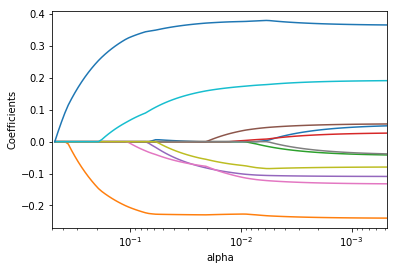

系数进入模型的次序所对应的属性排序 :
酒精含量
挥发性酸
亚硝酸盐
总二氧化硫
氯化物
非挥发性酸
PH值
游离二氧化硫
残留糖分
柠檬酸
密度
最佳回归系数： [ 0.         -0.22796371 -0.          0.         -0.0925528   0.01901807
 -0.09595566 -0.         -0.06611344  0.16679698  0.37461349]
最优alpha的系数尺度所对应的属性排序 :
酒精含量
挥发性酸
亚硝酸盐
总二氧化硫
氯化物
PH值
游离二氧化硫


In [16]:
# 沿用前面已经获得的数据

#  标准化与否的选择
# xx = xData; 
xx = xNormData
# y = yData
y = yNormData


alphas, coefs, _  = linear_model.lasso_path(xx, y,  return_models=False)

plt.plot(alphas,coefs.T)

plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.axis('tight')
plt.semilogx()
ax = plt.gca()
ax.invert_xaxis()
plt.show()

nattr, nalpha = coefs.shape

# 回归系数排序
nzList = []
for iAlpha in range(1,nalpha):
    coefList = coefs[: ,iAlpha]
    
    # 记录回归系数刚好变成非零的属性
    nzCoef = np.where(coefList!=0)[0]
    for q in nzCoef:
        if q not in nzList:
            nzList.append(q)

print ("系数进入模型的次序所对应的属性排序 :",)
for idx in nzList:
    print (df.columns[idx])

# 根据前面已获得的最佳\alpha，寻找此例中对应的索引
alphaStar = 0.013561387700964642
indexLTalphaStar = [index for index in range(100) if alphas[index] > alphaStar]
indexStar = max(indexLTalphaStar)

# 进而根据上面“对应的索引”，获得最佳回归系数值
coefStar = coefs[:,indexStar]
print ("最佳回归系数：", coefStar)

# 回归系数给出了另外一组稍微不同的顺序
absCoef =  np.abs(coefStar)
idxs = np.argsort(-absCoef)

print ("最优alpha的系数尺度所对应的属性排序 :",)
for idx in idxs:
    if absCoef[idx]!=0:
        print (df.columns[idx])

对于标准化属性， 上面两种属性的排序基本一致，但在不太重要的属性上有所差异。

对于非标准化属性，系数进入模型的次序几乎是混乱的，但最优alpha的系数尺度次序变化不大。

### 基扩展：基于原始属性扩展新属性来改进性能

本例尝试扩展了两个属性。

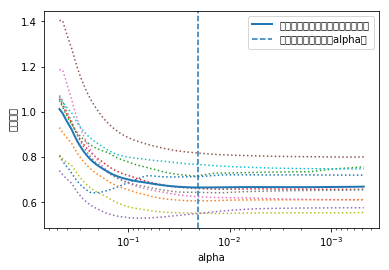

最小均方误差对应的alpha值   0.02060565714824037
最小均方误差： 0.6662830343122813


In [15]:
# 沿用前面已经获得的数据

# 扩展2个新属性
xExtData = np.concatenate((xData, np.zeros((m,2))), axis=1)
xExtData[:, n] = xData[:,-1]**2
xExtData[:, n+1] = xData[:,-1]*xData[:,1]

xNormExtData = (xExtData - xExtData.mean(axis=0))/np.std(xExtData,axis=0)

m, n = xData.shape

# 更新属性名
names = list(df.columns[idx])
names[-1] = "alco^2"
names.append("alco*volAcid")

#  标准化与否的选择
# xx = xExtData
xx = xNormExtData
# y = yData
y = yNormData

# 调用sklearn.linear_model中的LassoCV 
wineModel = LassoCV(cv=10).fit(xx, y)

# 显示结果
plt.figure()
plt.plot(wineModel.alphas_, wineModel.mse_path_, ':')
plt.plot(wineModel.alphas_, wineModel.mse_path_.mean(axis=-1),
         label='交叉验证结果的均方误差的平均值', linewidth=2)
plt.axvline(wineModel.alpha_, linestyle='--',
            label='交叉验证表现最佳的alpha值')
plt.semilogx()
plt.legend()
ax = plt.gca()
ax.invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('均方误差')
plt.axis('tight')
plt.show()

#print out the value of alpha that minimizes the Cv-error
print ("最小均方误差对应的alpha值  ",wineModel.alpha_)
print ("最小均方误差：", min(wineModel.mse_path_.mean(axis=-1)))